# Global imports

In [1]:
import os
import shutil
import requests
import zipfile
import warnings
from typing import List, Tuple, TypeAlias, Dict
from time import time as tt
from dataclasses import replace

import equinox as eqx
import jax.numpy as jnp
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib.pyplot import Figure, Axes
from jax import block_until_ready, grad, jacfwd, jit

subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
latex_installed = shutil.which("latex") is not None
plt.rcParams.update({
    'text.usetex': latex_installed,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 15
})

warnings.filterwarnings("ignore", category=UserWarning)
DEVICE = 'apple_M3pro'

def set_xlim(ax: Axes, xmin: float, xmax: float, border: float=0.02):
    xmin_margin =  xmin - (xmax-xmin)*border
    xmax_margin =  xmax + (xmax-xmin)*border
    ax.set_xlim(xmin_margin, xmax_margin)
def set_ylim(ax: Axes, ymin: float, ymax: float, border: float=0.02):
    ymin_margin =  ymin - (ymax-ymin)*border
    ymax_margin =  ymax + (ymax-ymin)*border
    ax.set_ylim(ymin_margin, ymax_margin)

# Wagner's LES
The data is available at the [Wagner's calibration repository](https://github.com/glwagner/SingleColumnModelCalibration.jl?tab=readme-ov-file).

## Download

In [2]:
do_run = False
if do_run:
    url = 'https://www.dropbox.com/scl/fi/8qwe9hf6wxc3w0crhzpml/profiles.zip?rlkey=sm8f7rhfokitzc7cgwinhip2k'
    url = url + '&dl=1'
    archive_file_name = 'tmp.zip'
    response = requests.get(url, allow_redirects=True)
    with open(archive_file_name, 'wb') as file:
        file.write(response.content)
    with zipfile.ZipFile(archive_file_name, 'r') as zipf:
        zipf.extractall()
    os.remove(archive_file_name)

## Global variables
Descriptions of the Wagner's LES database

In [3]:
LES_TIMEFRAMES = [6, 12, 24, 48, 72]
LES_SPACE_STEPS = [1, 2, 4]
LES_FORCINGS = [
    'free_convection',
    'weak_wind_strong_cooling',
    'med_wind_med_cooling',
    'strong_wind_weak_cooling',
    'strong_wind',
    'strong_wind_no_rotation',
    'strong_wind_and_sunny'
]
N_LES_T = len(LES_TIMEFRAMES)
N_LES_S = len(LES_SPACE_STEPS)
N_LES_F = len(LES_FORCINGS)

# link between Wagner's and Tunax names of the variables
LES_VAR_NAMES = {
    'variables': {
        'time': 'timeseries/t',
        'zr': 'grid/zᵃᵃᶜ',
        'zw': 'grid/zᵃᵃᶠ',
        'u': 'timeseries/u',
        'v': 'timeseries/v',
        'b': 'timeseries/b',
        'pt': 'timeseries/c'
    },
    'parameters': {
        'nz': 'grid/Nz',
        'fcor': 'parameters/coriolis_parameter'
    },
    'metadatas': {
        'u_str': 'parameters/momentum_flux',
        'b_str': 'parameters/buoyancy_flux',
        'pt_depth': 'parameters/tracer_forcing_depth',
        'pt_timescale': 'parameters/tracer_forcing_timescale',
        'pt_width': 'parameters/tracer_forcing_width',
        'sunny_flux': 'parameters/penetrating_buoyancy_flux'
    }
}

# on which dimensions load the variables
LES_DIMS = {
    'zr': (None,),
    'zw': (None,),
    'u': (None, 0, 0),
    'v': (None, 0, 0),
    'b': (None, 0, 0),
    'pt': (None, 0, 0)
}

LES_PATH = 'Wagner_LES'

NOTEBOOK_DATA_PATH = 'benchmark_Wagner_LES'
os.makedirs(NOTEBOOK_DATA_PATH, exist_ok=True)

## Rename folders and file

In [4]:
do_run = False
if do_run:
    os.rename('profiles', LES_PATH)
    for timeframe in LES_TIMEFRAMES:
        os.rename(os.path.join(LES_PATH, f'{timeframe}_hour_suite'), os.path.join(LES_PATH, f'{timeframe}h'))
        for space_step in LES_SPACE_STEPS:
            for forcing in LES_FORCINGS:
                os.rename(
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}_with_tracer_instantaneous_statistics.jld2'),
                    os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                )
    os.remove(os.path.join(LES_PATH, 'getsuite.sh'))

## Forcings
Described in [this paper](https://doi.org/10.48550/arXiv.2306.13204).

In [5]:
def forcing_passive_tracer(
        z: float,
        omega_p: float,
        lambda_c: float,
        zc: float,
        l_z: float
    ):
    omega_m = omega_p*lambda_c*jnp.sqrt(2*jnp.pi)/l_z
    fz = omega_p*jnp.exp(-(z-zc)**2/(2*lambda_c**2)) + omega_m
    return  fz

def forcing_buoyancy_sunny(
        z: float,
        jb: float,
        eps1: float,
        lambda1: float,
        lambda2: float,
    ):
    fz = -jb*(eps1/lambda1*jnp.exp(z/lambda1) + (1-eps1)/lambda2*jnp.exp(z/lambda2))
    return  fz

# New *Tunax*'s implementations
FILL HERE

# Runs directs
## Benchmark function
This function runs all the 105 cases of the Wagner's LES, with the old and all the new implementations of *Tunax*, and this for some number of trials. The output of all the simulations are written in NetCDF files, and the runtimes are recorded. Futhermore, we record if the function of total run (when it is a jitted function) is compilated again.

In [6]:
from tunax import SingleColumnModel as ModelOld
from tunax import Obs as ObsOld
from tunax.closures import KepsParameters as KepsParOld
from tunax_new import SingleColumnModel as ModelNew
from tunax_new import Obs as ObsNew
from tunax_new.closures import KepsParameters as KepsParNew
from tunax_new_case_tracable import SingleColumnModel as ModelNewTracable
from tunax_new_case_tracable import Obs as ObsNewTracable
from tunax_new_case_tracable.closures import KepsParameters as KepsParNewTracable

def benchmark_direct(n_trials: int, dt: float, tunax_version: str, run_method_name: str, experience: str):
    runtimes = np.zeros((N_LES_S, N_LES_T, N_LES_F, n_trials))
    compilations = np.zeros((N_LES_S, N_LES_T, N_LES_F, n_trials), dtype=bool)
    output_path = os.path.join('benchmark_Wagner_LES', 'direct', experience)
    runtimes_path = os.path.join(output_path, f'runtimes_{DEVICE}.npy')
    compilations_path = os.path.join(output_path, f'compilations_{DEVICE}.npy')
    os.makedirs(output_path, exist_ok=True)
    match tunax_version:
        case 'tunax':
            ObsClass = ObsOld
            KepsParClass = KepsParOld
        case 'tunax_new':
            ObsClass = ObsNew
            KepsParClass = KepsParNew
        case 'tunax_new_case_tracable':
            ObsClass = ObsNewTracable
            KepsParClass = KepsParNewTracable

    old_cache_size = 0
    pbar = tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES)*len(LES_FORCINGS), desc='simulation')
    for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
        for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
            for i_forcing, forcing in enumerate(LES_FORCINGS):
                jld2_filename = os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
                traj_output_path = os.path.join(output_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
                os.makedirs(os.path.dirname(traj_output_path), exist_ok = True)
                obs = ObsClass.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

                # case corrections
                obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
                new_case = replace(obs.case, b_forcing=(0., -obs.metadatas['b_str']))
                obs = eqx.tree_at(lambda t: t.case, obs, new_case)
                obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

                # passive tracer forcing
                omega_p = 1/obs.metadatas['pt_timescale']
                lambda_c = obs.metadatas['pt_width']
                zc = obs.metadatas['pt_depth']
                l_z = obs.trajectory.grid.hbot
                wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
                new_case = replace(obs.case, pt_forcing=wrapped_forcing_pt)
                if tunax_version != 'tunax_new_case_tracable':
                    new_case = replace(new_case, pt_forcing_type='constant')
                obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                # sunny forcing
                if forcing == 'strong_wind_and_sunny':
                    jb = obs.metadatas['sunny_flux']
                    eps1 = 0.6
                    lambda1 = 1.
                    lambda2 = 16.
                    wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
                    new_case = replace(obs.case, b_forcing=wrapped_forcing_b_sunny)
                    if tunax_version != 'tunax_new_case_tracable':
                        new_case = replace(new_case, b_forcing_type='constant')
                    obs = eqx.tree_at(lambda t: t.case, obs, new_case)

                # model instance
                traj_wagner = obs.trajectory
                init_state = traj_wagner.extract_state(0)
                match tunax_version:
                    case 'tunax':
                        timeframe_h = float(traj_wagner.time[-1]/3600)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        model = ModelOld(timeframe_h, dt, out_dt, init_state, obs.case, 'k-epsilon', traj_output_path)
                    case 'tunax_new':
                        nt = int(timeframe*3600/dt)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        p_out = int(out_dt/dt)
                        model = ModelNew(nt, dt, p_out, init_state, obs.case, 'k-epsilon')
                    case 'tunax_new_case_tracable':
                        nt = int(timeframe*3600/dt)
                        out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
                        p_out = int(out_dt/dt)
                        model = ModelNewTracable(nt, dt, p_out, init_state, obs.case, 'k-epsilon')

                # k-epsilon parameters
                keps_params = KepsParClass()

                for i_trial in tqdm(range(n_trials), desc='trials', leave=False):
                    # run the model
                    run_method = getattr(model, run_method_name)
                    start_time = tt()
                    traj = block_until_ready(run_method(keps_params))
                    runtimes[i_space_step, i_timeframe, i_forcing, i_trial] = tt() - start_time
                    if run_method_name in ['jit_run', 'jit_run_final_state']:
                        if run_method._cache_size() > old_cache_size:
                            compilations[i_space_step, i_timeframe, i_forcing, i_trial] = True
                            old_cache_size = run_method._cache_size()

                    # write the times and the cache size
                    np.save(runtimes_path, runtimes)
                    np.save(compilations_path, compilations)
                
                # write the output
                if tunax_version != 'tunax':
                    traj.to_nc(traj_output_path)

                pbar.update(1)
    pbar.close()

## Run all benchmarks

In [7]:
do_run = False

n_trials = 5
dt = 10.

if do_run:
    benchmark_direct(n_trials, dt, 'tunax', 'compute_trajectory_with', 'tunax_default')
    benchmark_direct(n_trials, dt, 'tunax_new', 'compute_trajectory_with', 'tridiag_scan')
    benchmark_direct(n_trials, dt, 'tunax_new', 'run_jit_step', 'temporal_loop_scan')
    benchmark_direct(n_trials, dt, 'tunax_new', 'jit_run', 'jit_outside')
    benchmark_direct(n_trials, dt, 'tunax_new', 'jit_run_final_state', 'no_intermediate_outputs')
    benchmark_direct(n_trials, dt, 'tunax_new_case_tracable', 'jit_run', 'array_forcings')

The run took 97 minutes on Macbook Pro with an Apple M3Pro CPU.

## Checking the results and consistency of new implementations
### Plot function

In [8]:
titles = {
    'free_convection': 'free convection',
    'weak_wind_strong_cooling': 'weak wind\nstrong cooling',
    'med_wind_med_cooling': 'med wind\nmed cooling',
    'strong_wind_weak_cooling': 'strong wind\nweak cooling',
    'strong_wind': 'strong wind',
    'strong_wind_no_rotation': 'strong wind\nno rotation',
    'strong_wind_and_sunny': 'strong wind sunny\n no rotation'
}

def plot_wag(timeframe: int, space_step: int, tunax_version:str, experience: str):
    sp: subplot_2D_type = plt.subplots(3, 7, sharey=True, figsize=(18, 12))
    _, [axs_b, axs_uv, axs_pt] = sp

    match tunax_version:
        case 'tunax':
            ObsClass = ObsOld
        case 'tunax_new':
            ObsClass = ObsNew
        case 'tunax_new_case_tracable':
            ObsClass = ObsNewTracable

    for i_forcing, forcing in enumerate(LES_FORCINGS):
        filename = os.path.join(LES_PATH, f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
        wagner_obs = ObsClass.from_jld2(filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)
        wagner_traj = wagner_obs.trajectory
        output_path = os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience)
        tunax_path = os.path.join(output_path, f'{timeframe}h', f'{space_step}m', f'{forcing}.nc')
        tunax_ds = xr.load_dataset(tunax_path)
        
        axs_b[i_forcing].plot(wagner_traj.b[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_b[i_forcing].plot(wagner_traj.b[-1, :], wagner_traj.grid.zr, 'r')
        if experience == 'no_intermediate_outputs':
            axs_b[i_forcing].plot(tunax_ds.b, wagner_traj.grid.zr, 'g')
        else:
            axs_b[i_forcing].plot(tunax_ds.b[-1, :], wagner_traj.grid.zr, 'g')
        if i_forcing > 0:
            axs_uv[i_forcing].plot(wagner_traj.u[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.u[-1, :], wagner_traj.grid.zr, 'r')
            if experience == 'no_intermediate_outputs':
                axs_uv[i_forcing].plot(tunax_ds.u, wagner_traj.grid.zr, 'g')
            else:
                axs_uv[i_forcing].plot(tunax_ds.u[-1, :], wagner_traj.grid.zr, 'g')
            axs_uv[i_forcing].plot(wagner_traj.v[0, :], wagner_traj.grid.zr, 'k--', linewidth=1)
            axs_uv[i_forcing].plot(wagner_traj.v[-1, :], wagner_traj.grid.zr, 'r--')
            if experience == 'no_intermediate_outputs':
                axs_uv[i_forcing].plot(tunax_ds.v, wagner_traj.grid.zr, 'g--')
            else:
                axs_uv[i_forcing].plot(tunax_ds.v[-1, :], wagner_traj.grid.zr, 'g--')
        axs_pt[i_forcing].plot(wagner_traj.pt[0, :], wagner_traj.grid.zr, 'k', linewidth=1)
        axs_pt[i_forcing].plot(wagner_traj.pt[-1, :], wagner_traj.grid.zr, 'r')
        if experience == 'no_intermediate_outputs':
            axs_pt[i_forcing].plot(tunax_ds.pt, wagner_traj.grid.zr, 'g')
        else:
            axs_pt[i_forcing].plot(tunax_ds.pt[-1, :], wagner_traj.grid.zr, 'g')
        axs_b[i_forcing].set_title(titles[LES_FORCINGS[i_forcing]])
    axs_b[0].set_ylabel(r'$b []$')
    axs_uv[1].set_ylabel(r'$u, v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    axs_pt[0].set_ylabel(r'passive tracer $[]$')
    axs_uv[0].plot([], [], 'g', label='tunax')
    axs_uv[0].plot([], [], 'r', label='LES')
    axs_uv[0].plot([], [], 'k', label='u')
    axs_uv[0].plot([], [], 'k--', label='v')
    axs_uv[0].text(-0.0, -40, f'time = {timeframe}h\nspace step = {space_step}m\n{experience}', fontsize=18, horizontalalignment='center')
    axs_uv[0].legend(loc='lower center')
    axs_uv[0].axis('off')
    axs_b[0].set_ylim(-200, 2)

### Plots for all new methods

In [9]:
do_run = False

timeframe = 24
space_step = 1

if do_run:
    plot_wag(timeframe, space_step, 'tunax', 'tunax_default')
    plot_wag(timeframe, space_step, 'tunax_new', 'tridiag_scan')
    plot_wag(timeframe, space_step, 'tunax_new', 'jit_outside')
    plot_wag(timeframe, space_step, 'tunax_new', 'temporal_loop_scan')
    plot_wag(timeframe, space_step, 'tunax_new', 'no_intermediate_outputs')
    plot_wag(timeframe, space_step, 'tunax_new_case_tracable', 'array_forcings')

## Runtimes
### Read datas

In [10]:
experience_list = ['tunax_default', 'tridiag_scan', 'temporal_loop_scan', 'jit_outside', 'no_intermediate_outputs', 'array_forcings']
runtimes_file_name = f'runtimes_{DEVICE}.npy'
compilations_file_name = f'compilations_{DEVICE}.npy'
runtimes_by_experience = {experience: np.load(os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience, runtimes_file_name)) for experience in experience_list}
compilations_by_experience = {experience: np.load(os.path.join(NOTEBOOK_DATA_PATH, 'direct', experience, compilations_file_name)) for experience in experience_list}

### Compilation effect and forcing comparisons
#### Plot function

In [11]:
def plot_comp_direct(timeframe: int, space_step: int):
    # plot parameters
    cmap = mpl.colormaps['Set1']
    color_comp = 'b'

    # figure
    sp: subplot_2D_type = plt.subplots(3, 3, figsize=(15, 10), width_ratios=(1, 1, .5), height_ratios=(1, 1, 1))
    fig, axes_array = sp
    fig.subplots_adjust(wspace=.2, hspace=.1)

    # axes
    axes_by_experience: Dict[str, Dict[str, Axes]] = {experience: axes_array[i_experience//2, i_experience%2] for i_experience, experience in enumerate(experience_list)}
    ax_title, ax_leg, ax_params = axes_array[0][-1], axes_array[1][-1], axes_array[2][-1]

    # suppression des ax
    for ax in [ax_title, ax_leg, ax_params]:
        ax.set_axis_off()

    # suppression des ticks
    for ax in axes_by_experience.values():
        ax.set_xticks([])

    # bar parameters
    width_trial = 1
    width_forcing = width_trial*(len(LES_FORCINGS)+1)
    n_forcing = len(LES_FORCINGS)
    i_timeframe = LES_TIMEFRAMES.index(timeframe)
    i_space_step = LES_SPACE_STEPS.index(space_step)

    # plots for all experience ax
    for experience, ax in axes_by_experience.items():
        # data
        runtimes = runtimes_by_experience[experience]
        compilations = compilations_by_experience[experience]
        n_trial = runtimes.shape[-1]
        # plot
        for i_trial in range(n_trial):
            for i_forcing in range(n_forcing):
                if compilations[i_space_step, i_timeframe, i_forcing, i_trial]:
                    color = color_comp
                else:
                    color = cmap(i_forcing/len(LES_FORCINGS))
                ax.bar(width_forcing*i_forcing + width_trial*i_trial, runtimes[i_space_step, i_timeframe, i_forcing, i_trial], width=width_trial, color=color)
        
    # legend
    for i_forcing, forcing in enumerate(LES_FORCINGS):
        ax_leg.bar(0., 0., color=cmap(i_forcing/len(LES_FORCINGS)), label=forcing)
    ax_leg.bar(0, 0, width=width_trial, color=color_comp, label='compilation of total run')
    ax_leg.legend(loc='center')

    # nom des axes
    for experience, ax in axes_by_experience.items():
        ax.set_xlabel(experience)
        ax.set_ylabel('runtime [s]')

    # titre
    ax_title.text(.5, .5, 'Direct run runtimes', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)
    _ = ax_params.text(.5, .5, f'timeframe = {timeframe}h\nspace step = {space_step}m\nn time steps = {int(timeframe*3600/10)}\nn space steps = {int(256/space_step)}', ha='center', va='center', transform=ax_params.transAxes)

#### Plots for extrem cases

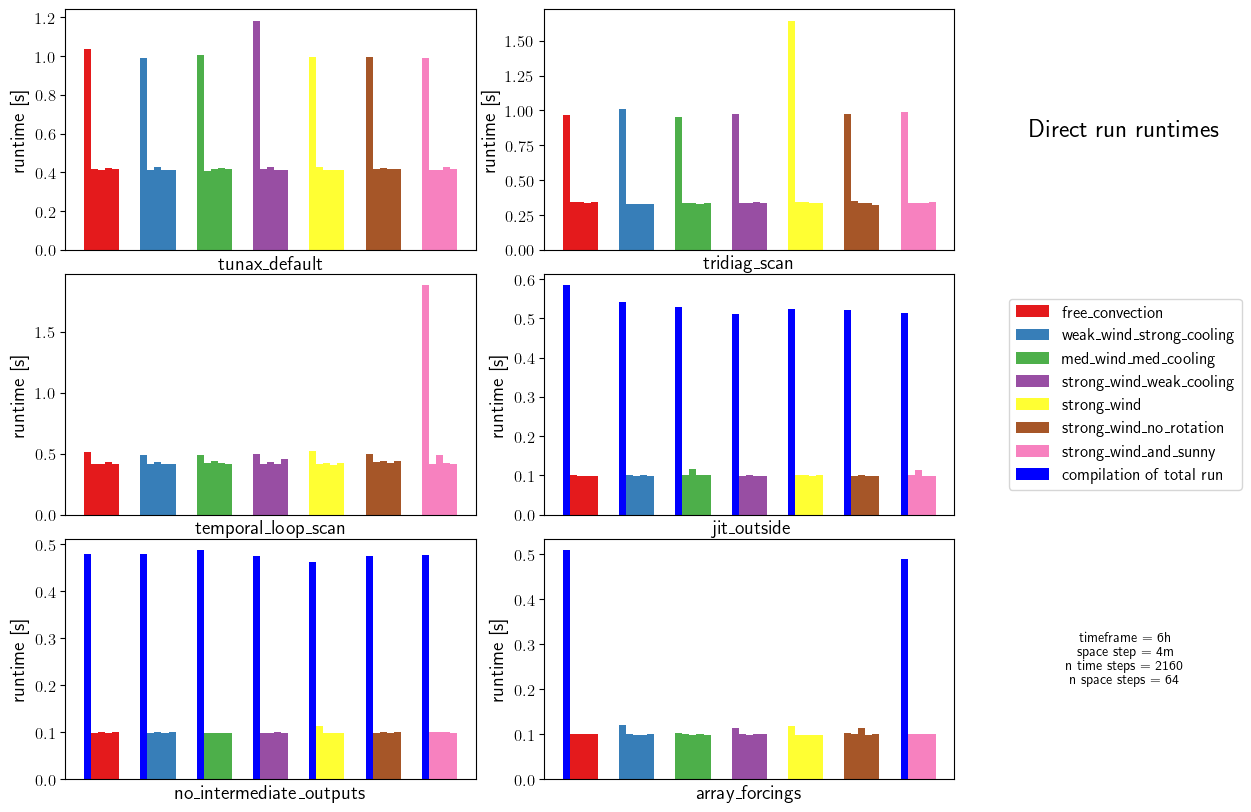

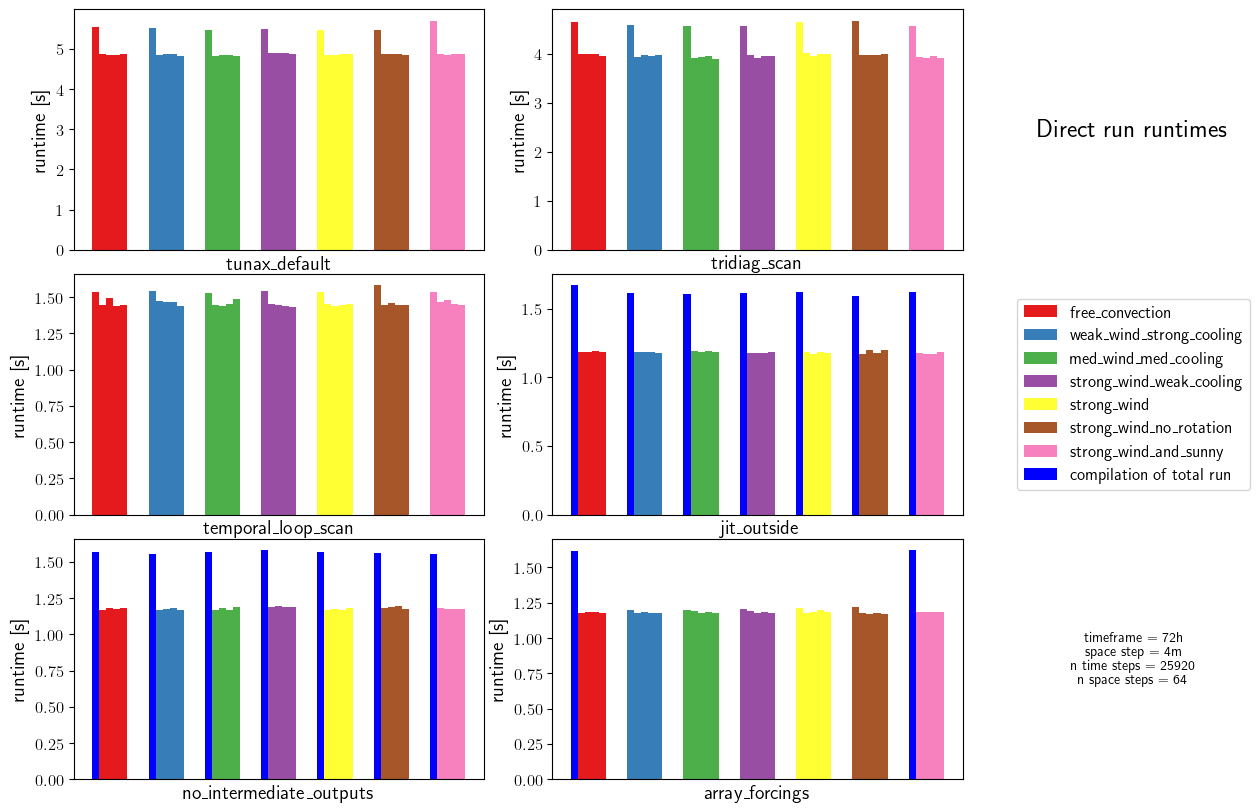

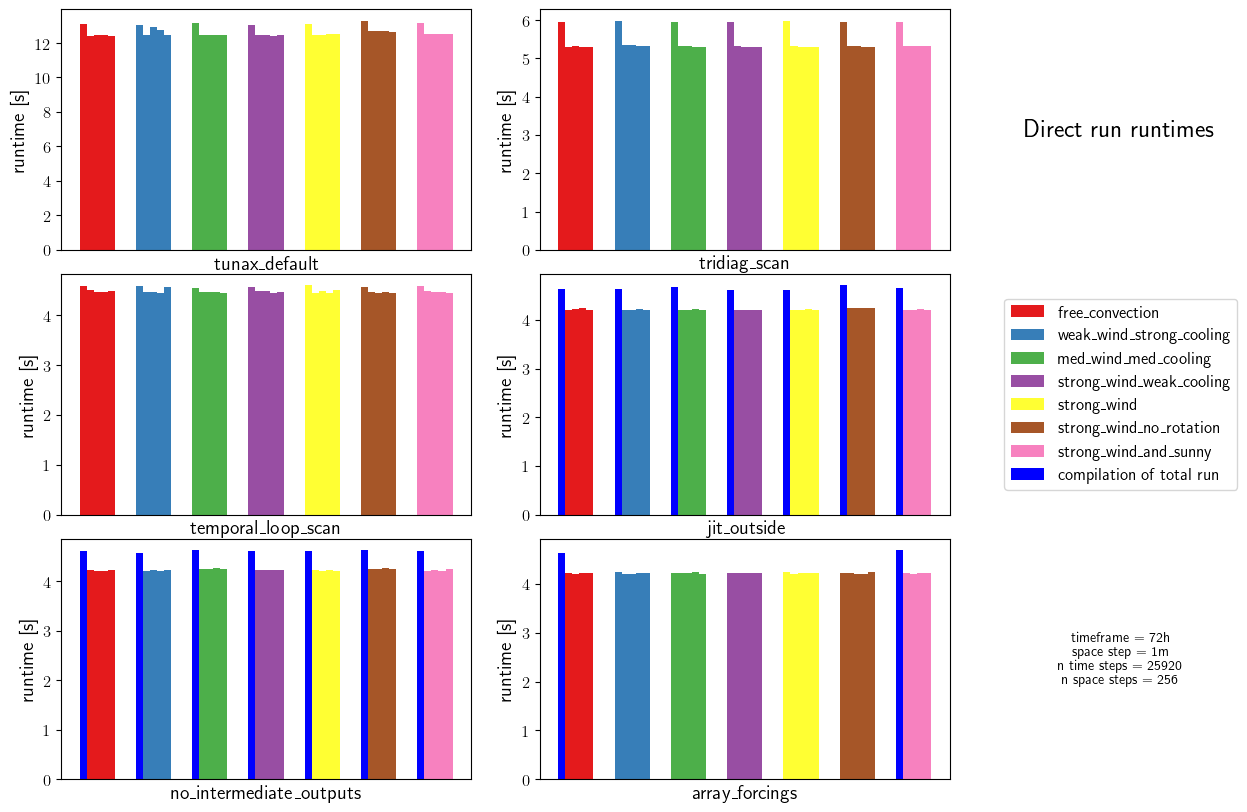

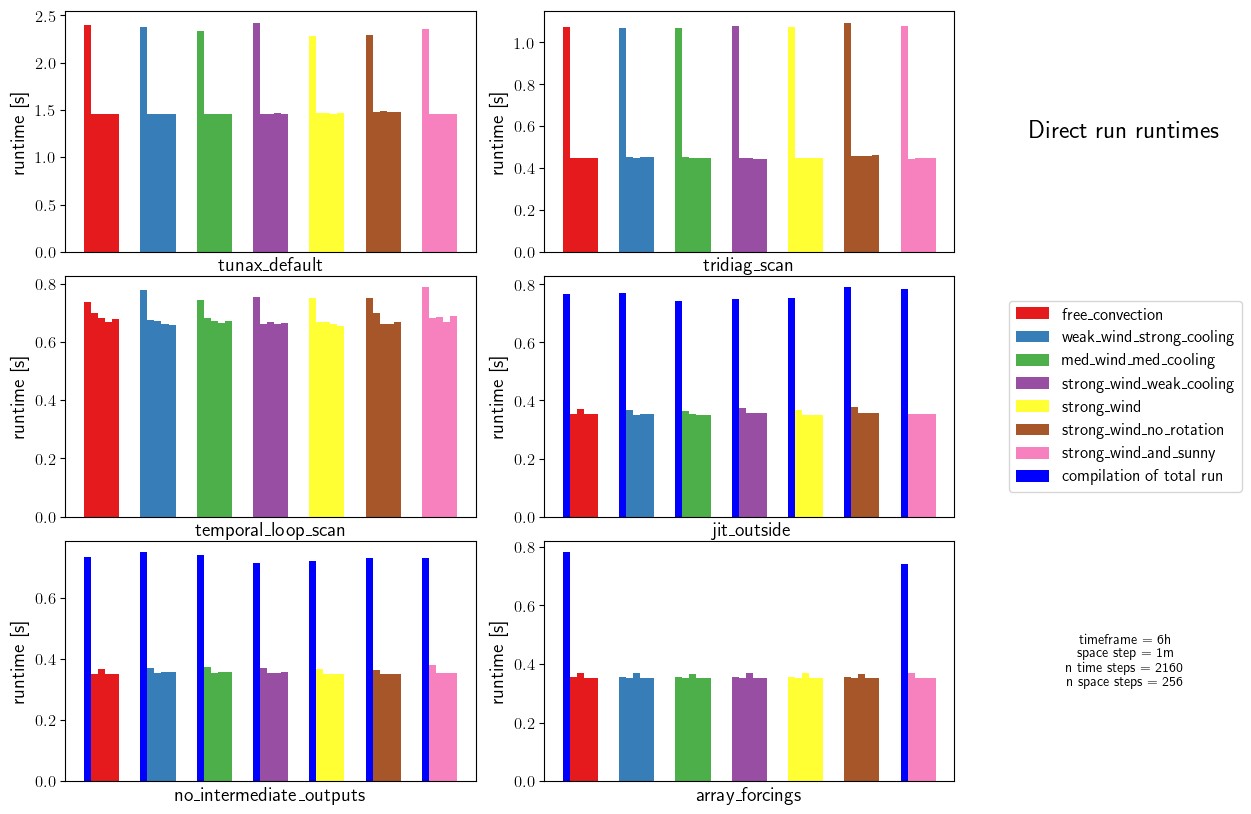

In [12]:
do_plot = True

if do_plot:
    plot_comp_direct(6, 4)
    plot_comp_direct(72, 4)
    plot_comp_direct(72, 1)
    plot_comp_direct(6, 1)

#### Analysis
- it works as espected : there is a compilation for every new forcing, and then the time of compiled version is smaller
- for the 3 first versions, it's not the total run which is compiled but smaller functions, it's not possible to get the confirmation of jax that there is a compilation here
- if the number of time steps increase, the ratio between the compilation time and the compiled time is smaller
- if the number of space steps increase, we have the same effect but less sensitive
- making the array as focings save some useless compilations (not a compilation by function (even if the values of the functions are the same), but a compilation by function signature)
- all the forcing have almost the sametime of execution : so we will to the time averaging on all the forcings and on the all the trials exept the first one

### Averaging

In [13]:
runtime_means = {experience: {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES} for experience in experience_list}
ratios = {timeframe: {space_step: np.zeros(1) for space_step in LES_SPACE_STEPS} for timeframe in LES_TIMEFRAMES}
for i_space_step, space_step in enumerate(LES_SPACE_STEPS):
    for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
        for experience in experience_list:
            runtime_means[experience][timeframe][space_step] = np.mean(runtimes_by_experience[experience][i_space_step, i_timeframe, 1:, :])
        ratios[timeframe][space_step] = runtime_means['tunax_default'][timeframe][space_step]/runtime_means['array_forcings'][timeframe][space_step]

### Method comparison
#### Plot

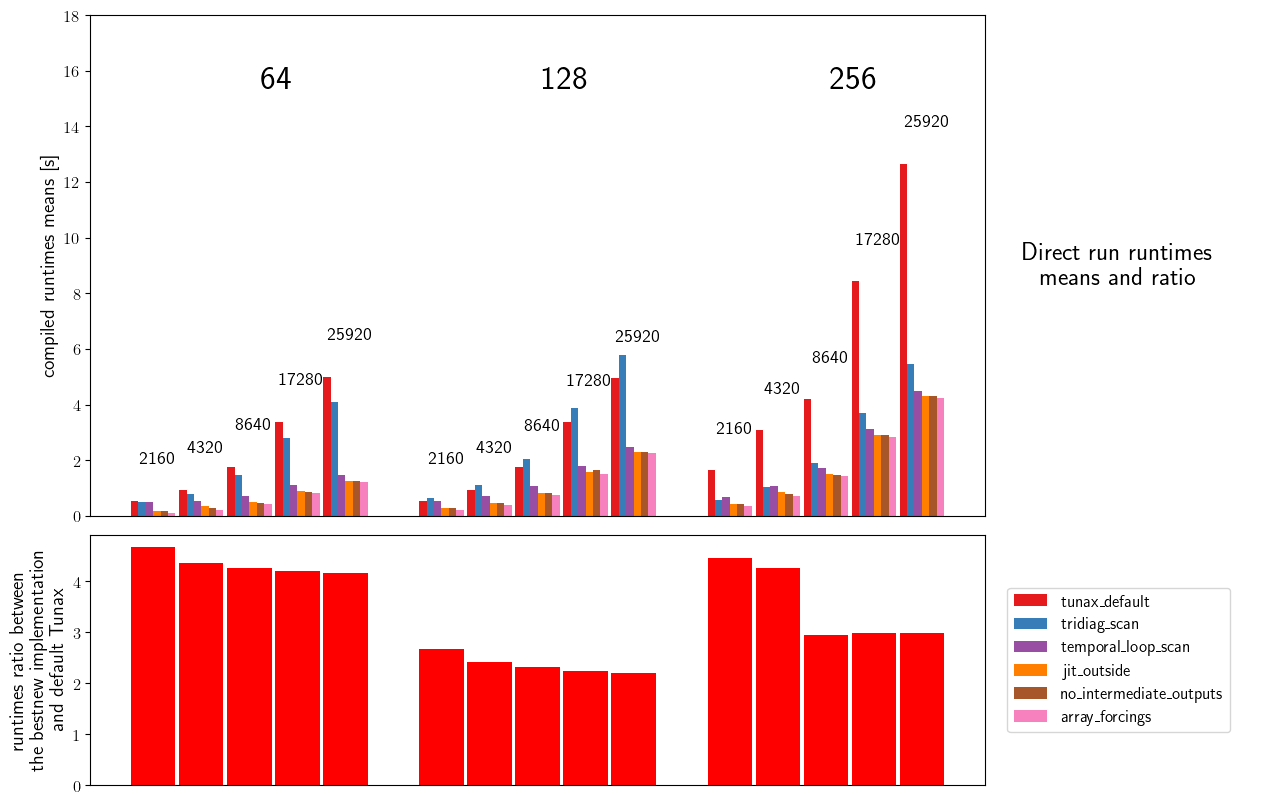

In [14]:
# plot parameters
cmap = mpl.colormaps['Set1']
color_ratios = 'r'

# figure
sp: subplot_2D_type = plt.subplots(2, 2, figsize=(15, 10), width_ratios=(1, .3), height_ratios=(1, .5))
fig, axes_array = sp
fig.subplots_adjust(wspace=0, hspace=.05)

# axes
ax_runtimes, ax_ratios, ax_title, ax_leg = axes_array[0][0], axes_array[1][0], axes_array[0][1], axes_array[1][1]

# suppression des ax
for ax in [ax_title, ax_leg]:
    ax.set_axis_off()

# suppression des ticks
for ax in [ax_runtimes, ax_ratios]:
    ax.set_xticks([])

# plot parameters
width_experience = 1
width_timeframe = width_experience*(len(LES_TIMEFRAMES)+1.5)
width_space_step = width_timeframe*(len(LES_TIMEFRAMES)+1)
width_ratio = width_experience*(len(LES_TIMEFRAMES)+1)

# plot for every experience, timeframe and space step
for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
    for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
        for i_experience, experience in enumerate(experience_list):
            ax_runtimes.bar(
                width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*i_experience,
                runtime_means[experience][timeframe][space_step], width=width_experience, color=cmap(i_experience/len(experience_list))
            )
        ax_ratios.bar(width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*len(experience_list)/2, ratios[timeframe][space_step], width=width_ratio, color=color_ratios)

# text for problem sizes
for i_space_step, space_step in enumerate(LES_SPACE_STEPS[::-1]):
    for i_timeframe, timeframe in enumerate(LES_TIMEFRAMES):
        ax_runtimes.text(
            width_space_step*i_space_step + width_timeframe*i_timeframe + width_experience*len(experience_list)/2,
            runtime_means['tunax_default'][timeframe][space_step]+1.5, int(timeframe*3600/10.), va='center', ha='center', fontsize=13
        )
    ax_runtimes.text(
        width_space_step*i_space_step + width_timeframe*len(LES_TIMEFRAMES)/2 + width_experience*len(experience_list)/2,
        runtime_means['tunax_default'][72][1]+3, int(256/space_step), va='center', ha='center', fontsize=24
    )

# limites
ax_runtimes.set_ylim(0, 18)

# legend
for i_experience, experience in enumerate(experience_list):
    ax_leg.bar(0., 0., color=cmap(i_experience/len(experience_list)), label=experience)
ax_leg.legend(loc='center')

# nom des axes
ax_runtimes.set_ylabel('compiled runtimes means [s]')
ax_ratios.set_ylabel('runtimes ratio between\nthe bestnew implementation\nand default Tunax')

# titre
_ = ax_title.text(.5, .5, 'Direct run runtimes\nmeans and ratio', fontsize=18, ha='center', va='center', transform=ax_title.transAxes)

#### Analysis
- the runtimes are growing with the number of time steps, almost lineary for all experiences
- the runtimes are growing with the number of space steps, not lineary, or 64 and 128 vertical levels we have almost the same runtimes, probably because there is an offset cost for small grids
- puting `lax.scan` for the tridiagonal inversion helps a lot the runtimes for large number of vertical levels
- putting `lax.scan` for the temporal loop helps a lot the runtime, expecially for small sizes
- surprisingly, putting `jit` outside the temporal loop doesn't decrease a lot the runtimes
- we have the same observation when we use the function that doesn't do indermediate outputs or the functions that use array forcings instead of functionnal forcings
- bewteen the best version that we can have the the default *Tunax* runtimes, we have ratios between 2 and 5, it's a good gain but not that much, they will probably be way larger for the gradient
- I made this runtimes on a GPU on Bigfoot (UGA cluster), but the times are exploding, war larger than these ones. The amount of calculation are probably to small to be ran on a gpu, maybe for the gradient it will be different

# Gradients
## Define a loss function
With the RMSE of the last buoyancy state
### For trajectories

In [15]:
def loss(parameters_array, fittable_parameters_set, model, obs, run_method_name):
    keps_params = fittable_parameters_set.fit_to_closure(parameters_array)
    run_method = getattr(model, run_method_name)
    traj_model = run_method(keps_params)
    traj_obs = obs.trajectory
    return jnp.sum((traj_model.b[-1, :]-traj_obs.b[-1, :])**2)

### For states

In [16]:
def loss_on_state(parameters_array, fittable_parameters_set, model, obs, run_method_name):
    keps_params = fittable_parameters_set.fit_to_closure(parameters_array)
    run_method = getattr(model, run_method_name)
    end_state, _, _ = run_method(keps_params)
    traj_obs = obs.trajectory
    return jnp.sum((end_state.b[:]-traj_obs.b[-1, :])**2)

## Run functions
Computing the gradients for every time step, forcing and timeframe would be too long. We write here a function that computes the gradient and the runtimes only for a specific set of these 3 parameters.

### List of experiments tested
FILL HERE

In [17]:
from tunax import SingleColumnModel as ModelOld
from tunax import Obs as ObsOld
from tunax import FittableParameter as FittableParameterOld
from tunax import FittableParametersSet as FittableParametersSetOld
from tunax.closures import KepsParameters as KepsParOld
from tunax_new import SingleColumnModel as ModelNew
from tunax_new import Obs as ObsNew
from tunax_new import FittableParameter as FittableParameterNew
from tunax_new import FittableParametersSet as FittableParametersSetNew
from tunax_new.closures import KepsParameters as KepsParNew
from tunax_new_case_tracable import SingleColumnModel as ModelNewTracable
from tunax_new_case_tracable import Obs as ObsNewTracable
from tunax_new_case_tracable import FittableParameter as FittableParameterNewTracable
from tunax_new_case_tracable import FittableParametersSet as FittableParametersSetNewTracable
from tunax_new_case_tracable.closures import KepsParameters as KepsParNewTracable

def benchmark_grad(n_trials: int, dt: float, timeframe: int, space_step: int, forcing: str, tunax_version: str, run_method_name: str, experience: str):
    runtimes = np.zeros(n_trials)
    compilations = np.zeros(n_trials, dtype=bool)
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience)
    runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    compilations_path = os.path.join(output_path, f'compilations_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    os.makedirs(output_path, exist_ok=True)
    match tunax_version:
        case 'tunax':
            ObsClass = ObsOld
            FittableParameter = FittableParameterOld
            FittableParametersSet = FittableParametersSetOld
        case 'tunax_new':
            ObsClass = ObsNew
            FittableParameter = FittableParameterNew
            FittableParametersSet = FittableParametersSetNew
        case 'tunax_new_case_tracable':
            ObsClass = ObsNewTracable
            FittableParameter = FittableParameterNewTracable
            FittableParametersSet = FittableParametersSetNewTracable

    old_cache_size = 0
    jld2_filename = os.path.join(LES_PATH,f'{timeframe}h', f'{space_step}m', f'{forcing}.jld2')
    obs = ObsClass.from_jld2(jld2_filename, LES_VAR_NAMES, None, LES_DIMS, eos_tracers='b', do_pt=True)

    # case corrections
    obs = eqx.tree_at(lambda t: t.case.ustr_sfc, obs, -obs.metadatas['u_str'])
    new_case = replace(obs.case, b_forcing=(0., -obs.metadatas['b_str']))
    obs = eqx.tree_at(lambda t: t.case, obs, new_case)
    obs = eqx.tree_at(lambda t: t.case.grav, obs, 9.80665)

    # passive tracer forcing
    omega_p = 1/obs.metadatas['pt_timescale']
    lambda_c = obs.metadatas['pt_width']
    zc = obs.metadatas['pt_depth']
    l_z = obs.trajectory.grid.hbot
    wrapped_forcing_pt = lambda z: forcing_passive_tracer(z, omega_p, lambda_c, -zc, l_z)
    new_case = replace(obs.case, pt_forcing=wrapped_forcing_pt)
    if tunax_version != 'tunax_new_case_tracable':
        new_case = replace(new_case, pt_forcing_type='constant')
    obs = eqx.tree_at(lambda t: t.case, obs, new_case)

    # sunny forcing
    if forcing == 'strong_wind_and_sunny':
        jb = obs.metadatas['sunny_flux']
        eps1 = 0.6
        lambda1 = 1.
        lambda2 = 16.
        wrapped_forcing_b_sunny = lambda z: forcing_buoyancy_sunny(z, jb, eps1, lambda1, lambda2)
        new_case = replace(obs.case, b_forcing=wrapped_forcing_b_sunny)
        if tunax_version != 'tunax_new_case_tracable':
            new_case = replace(new_case, b_forcing_type='constant')
        obs = eqx.tree_at(lambda t: t.case, obs, new_case)

    # model instance
    traj_wagner = obs.trajectory
    init_state = traj_wagner.extract_state(0)
    match tunax_version:
        case 'tunax':
            timeframe_h = float(traj_wagner.time[-1]/3600)
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            model = ModelOld(timeframe_h, dt, out_dt, init_state, obs.case, 'k-epsilon')
        case 'tunax_new':
            nt = int(timeframe*3600/dt)
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            p_out = int(out_dt/dt)
            model = ModelNew(nt, dt, p_out, init_state, obs.case, 'k-epsilon')
        case 'tunax_new_case_tracable':
            nt = int(timeframe*3600/dt)
            out_dt = float(traj_wagner.time[1] - traj_wagner.time[0])
            p_out = int(out_dt/dt)
            model = ModelNewTracable(nt, dt, p_out, init_state, obs.case, 'k-epsilon')

    # fittable parameters
    c_eps1_par = FittableParameter(True, val=1.44)
    c_eps2_par = FittableParameter(True, val=1.92)
    c_eps3m_par = FittableParameter(True, val=.4)
    c_eps3p_par = FittableParameter(True, val=1.)
    sig_k_par = FittableParameter(True, val=1.)
    sig_eps_par = FittableParameter(True, val=1.3)
    coef_dico = {
        'c_eps1': c_eps1_par,
        'c_eps2': c_eps2_par,
        'c_eps3m': c_eps3m_par,
        'c_eps3p': c_eps3p_par,
        'sig_k': sig_k_par,
        'sig_eps': sig_eps_par
    }
    fit_params_set = FittableParametersSet(coef_dico, 'k-epsilon')
    parameters_array = fit_params_set.gen_init_val()

    # k-epsilon parameters
    if 'fwd' in experience:
        grad_loss = jacfwd(loss, argnums=(0,))
    elif run_method_name == 'run_final_state':
        grad_loss = grad(loss_on_state, argnums=(0,))
    else:
        grad_loss = grad(loss, argnums=(0,))
    if 'jit' in experience:
        grad_loss = jit(grad_loss, static_argnames=('fittable_parameters_set', 'run_method_name'))

    for i_trial in tqdm(range(n_trials), desc=f'trials for {run_method_name}', leave=False):
        # run the model
        start_time = tt()
        block_until_ready(grad_loss(parameters_array, fit_params_set, model, obs, run_method_name))
        runtimes[i_trial] = tt() - start_time
        if 'jit' in experience:
            if grad_loss._cache_size() > old_cache_size:
                compilations[i_trial] = True
                old_cache_size = grad_loss._cache_size()

    # write the times and the cache size
    np.save(runtimes_path, runtimes)
    np.save(compilations_path, compilations)

### Run for extrem cases

In [18]:
do_run = False

n_trials = 5
dt = 10.
timeframe = 6
space_step = 4
forcing = 'free_convection'

if do_run:
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax', 'compute_trajectory_with', 'tunax_default')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'compute_trajectory_with', 'tridiag_scan')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'array_forcings_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'fwd_grad_jit')

The run took 6 minutes on Macbook Pro with an Apple M3Pro CPU.

In [19]:
do_run = False

n_trials = 2
dt = 10.
timeframe = 6
space_step = 1
forcing = 'free_convection'

if do_run:
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax', 'compute_trajectory_with', 'tunax_default')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'compute_trajectory_with', 'tridiag_scan')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'array_forcings_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'fwd_grad_jit')

The run took 2 minutes on Macbook Pro with an Apple M3Pro CPU.

In [20]:
do_run = False

n_trials = 2
dt = 10.
timeframe = 72
space_step = 4
forcing = 'free_convection'

if do_run:
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'fwd_grad_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'array_forcings_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'compute_trajectory_with', 'tridiag_scan')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax', 'compute_trajectory_with', 'tunax_default')

The run took 32 minutes on Macbook Pro with an Apple M3Pro CPU.

In [21]:
do_run = False

n_trials = 2
dt = 10.
timeframe = 72
space_step = 1
forcing = 'free_convection'

if do_run:
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'fwd_grad_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'array_forcings_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan_jit')
    benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan')

The run took 7 minutes on Macbook Pro with an Apple M3Pro CPU.

[28.15469217 25.81792808 26.21720481 23.58368278]
[25.38470602 23.28450203 21.61635399 20.82518411]
[4.49253297 5.75257206 4.41006994 4.38286805]
[4.8739078  0.72114015 0.73598599 0.79518008]
[3.42982721 3.21525812 3.39486003 4.43646598]
[4.47047615 0.962394   0.96679616 0.96355414]
[4.90974402 0.71736026 0.69860888 0.7910049 ]
[1.90313768 0.61856794 0.6043179  0.61298919]


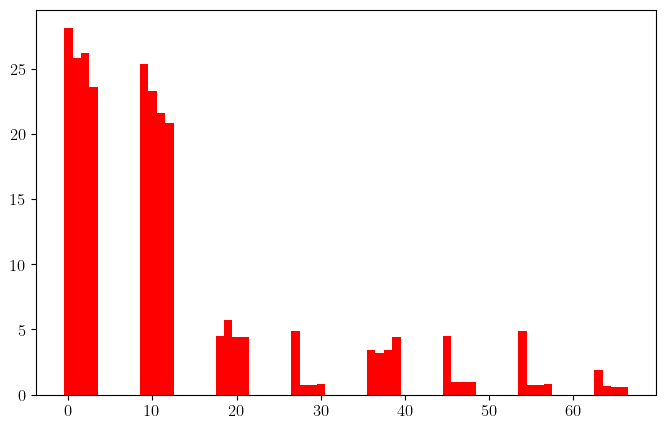

In [26]:
experience_list = ['tunax_default', 'tridiag_scan', 'temporal_loop_scan', 'temporal_loop_scan_jit', 'no_intermediate_outputs', 'no_intermediate_outputs_jit', 'array_forcings_jit', 'fwd_grad_jit']
n_trials = 5
dt = 10.
timeframe = 6
space_step = 4
forcing = 'free_convection'

color = 'r'

width_trial = 1
width_experience = width_trial*(len(experience_list)+1)
for i_experience, experience in enumerate(experience_list):
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience)
    runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    runtimes = np.load(runtimes_path)
    print(runtimes)
    n_trials, = runtimes.shape
    for i_trial in range(n_trials):
        plt.bar(i_experience*width_experience + i_trial*width_trial, runtimes[i_trial], width=width_trial, color=color)

[31.02146316 25.82673097 27.24118495 26.53609514]
[25.01384997 21.7954371  21.96722293 20.70133805]
[6.88454604 7.00276613 7.14468503 7.05606771]
[7.5713768  2.65775514 2.67546797 2.80551815]
[5.57560802 5.45021677 5.49751973 5.54939103]
[5.33691382 2.75377893 2.72273803 2.73777699]
[6.80778909 2.91386127 2.54088211 2.69616222]
[3.18138814 1.82328391 1.80846167 1.82820296]


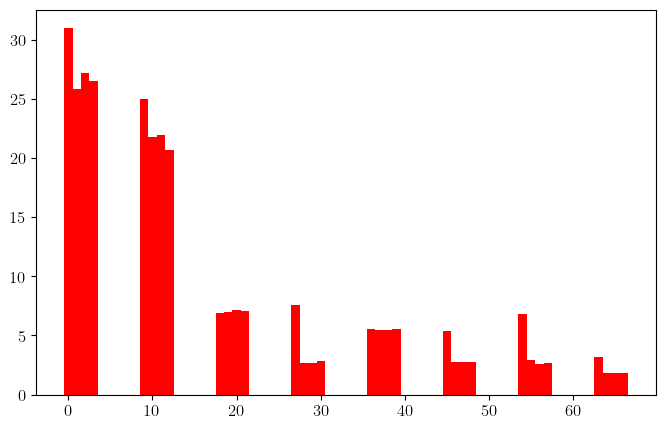

In [27]:
experience_list = ['tunax_default', 'tridiag_scan', 'temporal_loop_scan', 'temporal_loop_scan_jit', 'no_intermediate_outputs', 'no_intermediate_outputs_jit', 'array_forcings_jit', 'fwd_grad_jit']
n_trials = 5
dt = 10.
timeframe = 6
space_step = 1
forcing = 'free_convection'

color = 'r'

width_trial = 1
width_experience = width_trial*(len(experience_list)+1)
for i_experience, experience in enumerate(experience_list):
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience)
    runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    runtimes = np.load(runtimes_path)
    print(runtimes)
    n_trials, =  runtimes.shape
    for i_trial in range(n_trials):
        plt.bar(i_experience*width_experience + i_trial*width_trial, runtimes[i_trial], width=width_trial, color=color)

[477.08527708 523.78597331 499.65986609 467.45420599]
[399.35011888 405.6693809  406.41547489 410.12151098]
[12.81072783 13.32637596 13.09425902 18.13870096]
[13.22805715  8.91440105  8.97440481  8.68460488]
[13.9676168  14.10019708 14.19248915 14.076823  ]
[14.24752212 11.32585812 11.30003476 11.31547379]
[13.22919297  8.73856902  8.43885493  8.643538  ]
[8.42197609 6.67514706 6.60761404 6.77230692]


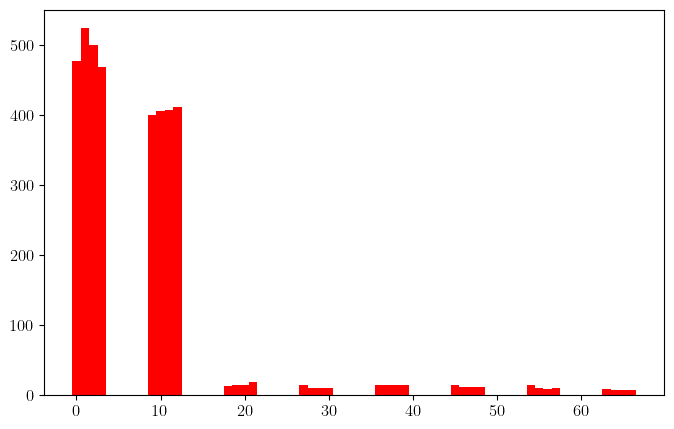

In [28]:
experience_list = ['tunax_default', 'tridiag_scan', 'temporal_loop_scan', 'temporal_loop_scan_jit', 'no_intermediate_outputs', 'no_intermediate_outputs_jit', 'array_forcings_jit', 'fwd_grad_jit']
n_trials = 5
dt = 10.
timeframe = 72
space_step = 4
forcing = 'free_convection'

color = 'r'

width_trial = 1
width_experience = width_trial*(len(experience_list)+1)
for i_experience, experience in enumerate(experience_list):
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience)
    runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    runtimes = np.load(runtimes_path)
    print(runtimes)
    n_trials, = runtimes.shape
    for i_trial in range(n_trials):
        plt.bar(i_experience*width_experience + i_trial*width_trial, runtimes[i_trial], width=width_trial, color=color)

[522.07129979 545.45686126 510.92278504 541.37323904]
[433.22469497 405.19796705 444.05563807 415.17066288]
[36.53225994 38.8387022  39.41995883 37.01513505]
[36.85738015 32.46378613 33.618922   33.51532173]
[38.40001917 38.66218114 39.25186086 38.92238784]
[37.03787374 33.78461885 34.90474486 33.76725984]
[36.00189281 30.70802307 31.00690627 31.19837308]
[23.77123189 22.43355227 22.41066599 22.41004896]


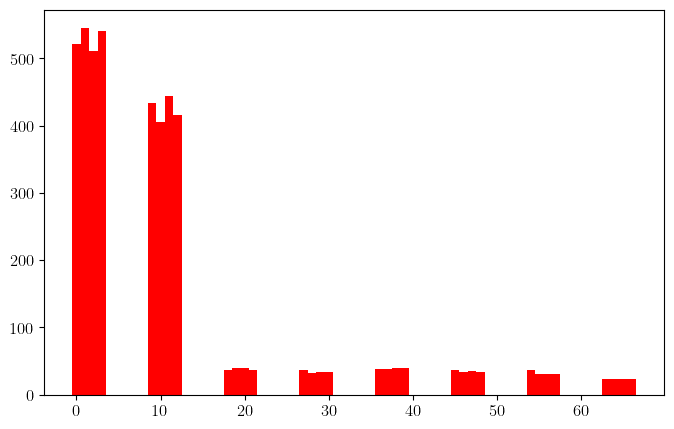

In [29]:
experience_list = ['tunax_default', 'tridiag_scan', 'temporal_loop_scan', 'temporal_loop_scan_jit', 'no_intermediate_outputs', 'no_intermediate_outputs_jit', 'array_forcings_jit', 'fwd_grad_jit']
n_trials = 5
dt = 10.
timeframe = 72
space_step = 1
forcing = 'free_convection'

color = 'r'

width_trial = 1
width_experience = width_trial*(len(experience_list)+1)
for i_experience, experience in enumerate(experience_list):
    output_path = os.path.join(NOTEBOOK_DATA_PATH, 'grads', experience)
    runtimes_path = os.path.join(output_path, f'runtimes_{timeframe}h_{space_step}m_{forcing}_{DEVICE}.npy')
    runtimes = np.load(runtimes_path)
    print(runtimes)
    n_trials, = runtimes.shape
    for i_trial in range(n_trials):
        plt.bar(i_experience*width_experience + i_trial*width_trial, runtimes[i_trial], width=width_trial, color=color)

In [25]:
do_run = True

n_trials = 4
dt = 10.
forcing = 'free_convection'

if do_run:
    pbar= tqdm(total=len(LES_SPACE_STEPS)*len(LES_TIMEFRAMES), desc='simulation')
    for timeframe in LES_TIMEFRAMES:
        for space_step in LES_SPACE_STEPS:
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'fwd_grad_jit')
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new_case_tracable', 'run', 'array_forcings_jit')
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs_jit')
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run_final_state', 'no_intermediate_outputs')
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan_jit')
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'run', 'temporal_loop_scan')
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax_new', 'compute_trajectory_with', 'tridiag_scan')
            benchmark_grad(n_trials, dt, timeframe, space_step, forcing, 'tunax', 'compute_trajectory_with', 'tunax_default')
            pbar.update(1)
    pbar.close()

simulation:   0%|          | 0/15 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run_final_state:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for run:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]

trials for compute_trajectory_with:   0%|          | 0/4 [00:00<?, ?it/s]